In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import importlib
import pandas as pd
import matplotlib.gridspec as gridspec
import time

import sys
sys.path.append('../scripts')

import sirs
import params
import plotting
import stability
from params import cols

plotting.set_rcParams()

## Timeseries

Code to reproduce a timeseries of the infectious compartment. The model is found under scripts/sirs and the parameters under scripts/params. Furthermore, the code finds all peaks of the infectious timeseries, which allows to compute the peak diagram of Figure 3 (a), see below

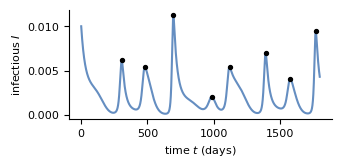

In [74]:
importlib.reload(sirs)

cm = 1/2.54
fig,ax = plt.subplots(1,1,figsize=(8.6*cm,3.6*cm))


p = params.p
p['tmax'] = 5*360
p['mmax'] = 0.845
p['tau'] = 30

m = sirs.model(**p)

t,y,t_events,events = m.run()


ax.plot(m.times, m.data[1,:], color=cols[1])
ax.set_xlabel('time $t$ (days)')
ax.set_ylabel('infectious $I$')

ax.scatter(m.t_events,m.events[0][:,1],color='black',s=8,zorder=2)

### Figure 1, panels (b) and (c)

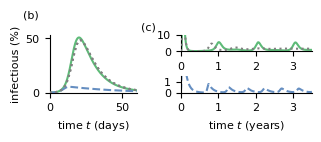

In [75]:
cm = 1/2.54
fig = plt.figure(figsize=(8.6*cm,2))


gs = gridspec.GridSpec(nrows=2, ncols=2, top=0.4, wspace=0.4, hspace=1.5,width_ratios=[1,1.5])

axs = [0]*3
axs[0] = fig.add_subplot(gs[:, 0])
axs[1] = fig.add_subplot(gs[0, 1])
axs[2] = fig.add_subplot(gs[1, 1])



importlib.reload(params)
p = params.p

p['mmax'] = 0.84
p['a'] = 0.3
p['y0'] = [0.999,0.001,0,0,0.00]
p['tmax'] = 6000

m = sirs.model(**p)
m1 = sirs.model(**p)
m2 = sirs.model(**p)

m.a = 0
m.mmax = 0
m.nu = 1/500
m1.mmax = 0
m1.nu = 1/500
m2.a = 0

a,b,c,d = m.run()
a,b,c,d = m1.run()
a,b,c,d = m2.run()



axs[0].plot(m.times,100*m.data[1,:],color='grey',ls=':',zorder=4)


for ax in [axs[0],axs[1]]:
    ax.plot(m.times,100*m.data[1,:],color='grey',ls=':',zorder=4)
    ax.plot(m1.times,100*m1.data[1,:],color=cols['seasonality_I'])
    
for ax in [axs[0],axs[2]]:
    ax.plot(m2.times,100*m2.data[1,:],color=cols['feedback_I'],ls='--')
    


axs[0].set_xlabel('time $t$ (days)')
axs[0].set_ylabel('infectious (%)')

axs[2].set_xlabel('time $t$ (years)')


for i in range(3):
    axs[i].set_ylim(0,None)
    axs[i].set_xlim(0,None)


axs[0].set_xlim(0,60)
axs[1].set_ylim(0,10)
axs[2].set_ylim(0,1.5)


    
for i in [1,2]:
    axs[i].set_xlim(0,360*3+180)
    axs[i].set_xticks([0,360,2*360,3*360])
    axs[i].set_xticklabels(['0','1','2','3'])


for lab, i in zip(['b','c'],[0,1]):
    plotting.setabc(axs[i],lab,x=-0.3,y=1.3)


### Figure 2, scenario time series

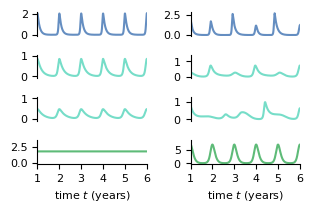

In [79]:
cm = 1/2.54
fig = plt.figure(figsize=(8.6*cm,5*cm))

gsb = gridspec.GridSpec(nrows=4, ncols=2, wspace=0.4, hspace=0.8)

axsb = [0]*9
axsb[1] = fig.add_subplot(gsb[0, 0])
axsb[2] = fig.add_subplot(gsb[1, 0])
axsb[3] = fig.add_subplot(gsb[2, 0])
axsb[4] = fig.add_subplot(gsb[3, 0])

axsb[5] = fig.add_subplot(gsb[0, 1])
axsb[6] = fig.add_subplot(gsb[1, 1])
axsb[7] = fig.add_subplot(gsb[2, 1])
axsb[8] = fig.add_subplot(gsb[3, 1])


for _ in [1,2,3,5,6,7]:
    axsb[_].spines['bottom'].set_visible(False)
    axsb[_].set_xticks([])

    
    
importlib.reload(params)
p = params.p


p['y0'] = [0.99,0.01,0,0.005,0.005]
p['a'] = 0.25
p['tmax'] = 20000



for _ in [1,2,3,4]:    
    mmax = params.scenarios['mmax'][_]
    tau = params.scenarios['tau'][_]
    p['mmax']=mmax
    p['tau']=tau
    m = sirs.model(**p)
    t,d,e,te = m.run()
    
    m_no_s = sirs.model(**p)
    m_no_s.a=0
    t,d,e,te = m_no_s.run()
    
    
    axsb[_].plot(m_no_s.times,100*m_no_s.data[1,:],color=cols[_])
    
    axsb[_+4].plot(m.times,100*m.data[1,:],color=cols[_])
    
    axsb[_].tick_params(axis='y', labelsize=8)
    axsb[_+4].tick_params(axis='y', labelsize=8)
    
    nrpeaks = 7
    
    for ax,model in zip([axsb[_],axsb[_+4]],[m_no_s,m]):
        lastpeaks = model.t_events[0][-nrpeaks:-1:1]
        ax.set_xticks([])
        ax.set_xlim(lastpeaks[0],lastpeaks[-1])
        ax.set_ylim(-0.1,None)
        
        if ax == axsb[4] or ax == axsb[8]:
            
            ax.set_xlabel('time $t$ (years)')
            ax.set_xticks(lastpeaks)
            ax.set_xticklabels(np.arange(1,nrpeaks))
    

## Stability diagrams

Code that produces a stability diagram of the endemic state in the tau-mmax plane. It is computed via the sign of the largest eigenvalue of the Jacobian at the endemic equilibrium. Code is found under scripts/stability. Further below is code that finds the Hopf bifurcation curve that was plotted in figure 2 (a), (b)

In [3]:
p = params.p

mmaxline = np.linspace(0.7,1,250)
tauline = np.linspace(0.05,50,250)


M = stability.calc_stabilitymatrix(p,beta=0.5,mmaxline=mmaxline,tauline=tauline)

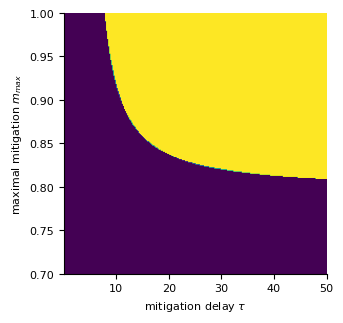

In [6]:
cm = 1/2.54
fig,ax = plt.subplots(1,1,figsize=(8.6*cm,8.6*cm))

plt.imshow(np.flip(M,axis=1).transpose(),aspect='auto',extent=(tauline.min(), tauline.max(), mmaxline.min(), mmaxline.max()))

ax.set_xlabel(r'mitigation delay $\tau$')
ax.set_ylabel('maximal mitigation $m_{max}$');

### Fiure 2, stability diagrams

In [86]:
p = params.p
mmaxline = np.linspace(0.7,1,250)
tauline = np.linspace(0.05,50,250)
path_base = '../simulations/hopfcurves/'
beta_0 = 0.5


stability.calc_hopfcurve(f'{path_base}hopfcurve_R0=5.csv',p,beta_0, mmaxline=mmaxline, tauline=tauline)
stability.calc_hopfcurve(f'{path_base}hopfcurve_R0=5_summer.csv',p,beta_0*(1-p['a']), mmaxline=mmaxline, tauline=tauline)
stability.calc_hopfcurve(f'{path_base}hopfcurve_R0=5_winter.csv',p,beta_0*(1+p['a']), mmaxline=mmaxline, tauline=tauline)


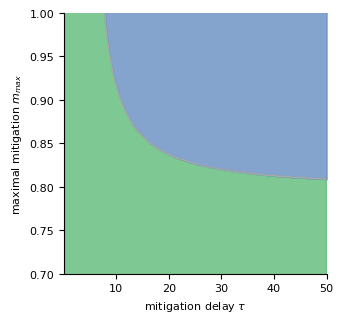

In [103]:
cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.6*cm,8.6*cm))

plotting.plot_stability(ax,f'{path_base}hopfcurve_R0=5.csv',mmaxline,tauline,alpha=0.8)

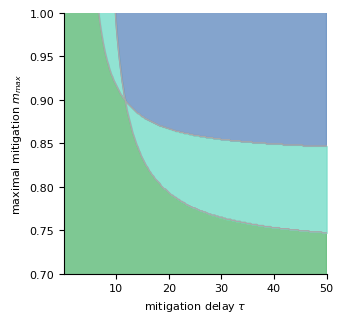

In [104]:
cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.6*cm,8.6*cm))

plotting.plot_metastability(ax,f'{path_base}hopfcurve_R0=5_summer.csv',f'{path_base}hopfcurve_R0=5_winter.csv',mmaxline,tauline,alpha=0.8)



### Bifurcation diagram of Fig. 3 (a)

The bifurcation diagram can be computed by varying the parameter $a$ and collecting many peaks of the steady state timeseries, and scattering one against the other. In principle, the code found in scripts/sirs can be used for that purpose, as it automatically returns the peaks of the infectious timeseries. All one has to do is write a loop to vary parameter $a$. The file used below for the bifurcation diagram was created in C instead due to the higher performance than in Python

In [9]:
bifurcation = '../simulations/cluster/bifurcationdiagrams/bifurcation_a=0-0,4_tau=32,5_mmax=0,85.dat'

res_bif = pd.read_csv(bifurcation,sep=',')

Text(0, 0.5, 'infectious at wave peaks (%)')

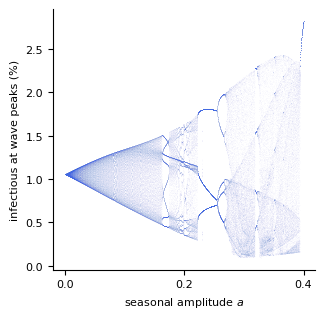

In [10]:


cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.6*cm,8.6*cm))


plotting.plot_bifurcation(res_bif,ax,'a',lw=0.05)
ax.set_xticks([0,0.2,0.4])

ax.set_xlabel(r'seasonal amplitude $a$')
ax.set_ylabel('infectious at wave peaks (%)');